# NLP: Project2
Students: Marco RIVA, Michele PULVIRENTI

In [32]:
# Kernel preparation and imports statements
!pip install -q openpyxl
!pip install -q fast-langdetect
!pip install -q wordcloud
!pip install -q textblob
!pip install -q textblob-fr
!pip install -q symspellpy
!pip install -q gensim
!pip install -q tensorflow
!pip install -q tensorboard
!pip install -q git+https://github.com/ddobrinskiy/streamlit-jupyter.git

import pandas as pd
pd.options.mode.chained_assignment = None
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from fast_langdetect import detect
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from gensim.models import Word2Vec
import tensorflow as tf
import tempfile

# 1.-2. Data Processing
As first step, lets inspect the dataset.

## Data loading
The dataset is split in 35 different files. Each of them will be loaded and concatenated in a single dataframe.

In [18]:
data_path = './Traduction avis clients'
models_path = './models'

data_files = [f'avis_{i}_traduit.xlsx' for i in range(1, 36)]

columns_dtypes = {
    'note': 'float',
    'auteur': 'string',
    'avis': 'string',
    'assureur': 'string',
    'produit': 'string',
    'type': 'string',
    'date_publication': 'string',
    'date_exp': 'string',
    'avis_cor': 'string',
    'avis_en': 'string',
    'avis_cor_en': 'string'
}

In [19]:
df = pd.concat([pd.read_excel(os.path.join(data_path, file), engine='openpyxl', dtype=columns_dtypes) for file in data_files], ignore_index=True)
df

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,5.0,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto,train,06/09/2021,01/09/2021,"Best insurance, price, solutions, listening, s...",<NA>,<NA>
1,4.0,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto,train,03/05/2021,01/05/2021,"I am generally satisfied, except that you have...",<NA>,<NA>
2,5.0,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto,train,21/03/2021,01/03/2021,Very affordable price Several options are avai...,<NA>,<NA>
3,4.0,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto,train,10/06/2021,01/06/2021,"I satisfy the service, a very fast response fr...",<NA>,<NA>
4,1.0,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto,train,29/01/2017,01/01/2017,"Customer for more than 25 years, very disappoi...",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,"Bonjour, j'ai une mauvaise expérience avec la ...",Sma,garantie-decennale,test,24/08/2021,01/08/2021,"Hello, I have a bad experience with the Socoba...","Bonjour, j'ai une mauvaise expérience avec la ...","Hello, I have a bad experience with the Socoba..."
34431,NaN,tarti-88637,Entreprise très impactée par le covid- secteur...,Allianz,assurances-professionnelles,test,18/05/2021,01/05/2021,Company very impacted by the covid- event sect...,Entreprise très impactée par le covid- secteur...,<NA>
34432,NaN,victor-109599,"Suite a un cambriolage le 22/01/2021, je suis ...",Allianz,assurances-professionnelles,test,08/04/2021,01/04/2021,"Following a burglary on 01/22/2021, I am still...","Suite a un cambriolage le 22/01/2021, je suis ...",<NA>
34433,NaN,lkio-110907,"Bonjour, Je constate qu'entre le moment de ma...",Generali,assurances-professionnelles,test,19/04/2021,01/04/2021,"Hello, I note that between the time of my req...","Bonjour, Je constate qu'entre le moment de ma...",<NA>


## Basic information
This section prints same basic information for the entire dataset.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34435 entries, 0 to 34434
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   note              24104 non-null  float64
 1   auteur            34434 non-null  string 
 2   avis              34435 non-null  string 
 3   assureur          34435 non-null  string 
 4   produit           34435 non-null  string 
 5   type              34435 non-null  string 
 6   date_publication  34435 non-null  string 
 7   date_exp          34435 non-null  string 
 8   avis_en           34433 non-null  string 
 9   avis_cor          435 non-null    string 
 10  avis_cor_en       431 non-null    string 
dtypes: float64(1), string(10)
memory usage: 2.9 MB


In [21]:
df.nunique()

note                    5
auteur              33569
avis                34377
assureur               56
produit                13
type                    2
date_publication     1815
date_exp               61
avis_en             33264
avis_cor              435
avis_cor_en           431
dtype: int64

In [22]:
df.isna().sum()

note                10331
auteur                  1
avis                    0
assureur                0
produit                 0
type                    0
date_publication        0
date_exp                0
avis_en                 2
avis_cor            34000
avis_cor_en         34004
dtype: int64

## Train-Test split inspection

We can notice that the dataset is already provided with a train-test division, using the 'type' column.

The test set is provided with the coluns **avis_cor** and **avis_cor_en** filled, and without the **note** column. We can then split the dataset, using the already provided division.

In [23]:
df_train = df[df['type'] == 'train']
df_test = df[df['type'] == 'test']

In [24]:
print(df_train.shape)
df_train.isna().sum()

(24104, 11)


note                    0
auteur                  1
avis                    0
assureur                0
produit                 0
type                    0
date_publication        0
date_exp                0
avis_en                 1
avis_cor            24104
avis_cor_en         24104
dtype: int64

In [25]:
print(df_test.shape)
df_test.isna().sum()

(10331, 11)


note                10331
auteur                  0
avis                    0
assureur                0
produit                 0
type                    0
date_publication        0
date_exp                0
avis_en                 1
avis_cor             9896
avis_cor_en          9900
dtype: int64

## Data Cleaning

In this section we will perform some basic data cleaning operations on the dataset. In order to have a fare dataset, these operations will be perfomed on the full dataset (the **df** ojbect), which will be later (again) splitted in train and test sets using the already provided division.

The following operations will be performed:
- Drop rows with missing values
- Remove empty reviews
- Remove non-text characters
- Detect language
- Perform spelling correction
- Lower text
- Remove stopwords and punctualization
- Save the cleaned dataset

### Null values

As result of the previous cells, we can see that the dataset has practically no null values.

In total, there are only 3 unexpected missing values, located in the **auteur** and **aivs_en** columns.

The related rows will be dropped.

In [26]:
df = df.dropna(subset=['auteur', 'avis_en'])

### Empty reviews

We can also notice that there are no empty reviews in the dataset.

In [27]:
print('empty reviews (avis + avis_en):', len(df_train[df_train['avis'] == '']) + len(df_train[df_train['avis_en'] == '']))

empty reviews (avis + avis_en): 0


### Foreign characters

We can also notice that there are no non-text characters in the reviews.

In [28]:
def clean_text(text):
    # Keep Unicode letters, digits, spaces, and basic punctuation
    return re.sub(r'[^\w\s.,!?\'\"-]', '', text.replace("\n", ""), flags=re.UNICODE)

def clean_reviews(df, columns):
    for column in columns:
        df[column] = df[column].apply(clean_text)
    
clean_reviews(df, ['avis', 'avis_en'])

In [29]:
# print the review's row, if the cleaned review is different from the original one
for row in df.itertuples():
    if row.avis != df.loc[row.Index, 'avis']:
        print(row.avis)
        print(df.loc[row.Index, 'avis'])
    if row.avis_en != df.loc[row.Index, 'avis_en']:
        print(row.avis_en)
        print(df.loc[row.Index, 'avis_en'])
# we can see that nothing is printed

### Language detection

Basic language dection will be performed on the reviews, in order to check if the reviews are all in french as expected.

In [27]:
def detect_language(text):
    try:
        return detect(text, low_memory=False)["lang"]
    except Exception:
        return 'unknown'

def annotate_language(df, column):
    df['language'] = df[column].apply(detect_language)
    
annotate_language(df, 'avis')
print(df['language'].value_counts())

[2025-01-05 19:11:11,056][INFO] - Downloading https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin to lid.176.bin (125.2M)


  0%|          | 0.00/125M [00:00<?, ?B/s]

language
fr    34290
en       96
ro        8
es        7
sr        5
ca        4
it        4
la        4
pt        3
de        2
fi        1
eo        1
sv        1
sk        1
zh        1
cs        1
hu        1
pl        1
vo        1
Name: count, dtype: int64


Observing the previous result, it may seems that there are some reviews acutally not in french. We can then inspect these reviews.

In [28]:
df[df['language'] == 'en']

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en,language
209,1.0,pasmaaf-54702,accident renault zoé,MAAF,auto,train,15/05/2017,01/05/2017,renault zoé accident,<NA>,<NA>,en
235,4.0,eric-p-109172,bonne assurance telephone facilite acces simpl...,Direct Assurance,auto,train,05/04/2021,01/04/2021,good telephone insurance facilitates simple an...,<NA>,<NA>,en
474,3.0,santaguiala-89467,assurance vie bnp cardif,Cardif,vie,train,07/05/2020,01/05/2020,bnp cardif life insurance,<NA>,<NA>,en
649,5.0,lahcen-c-127203,direct assurance contente simple rapide plus a...,Direct Assurance,auto,train,09/08/2021,01/08/2021,"with direct insurance, i'm happy it's simple a...",<NA>,<NA>,en
1054,1.0,kiko1971-58363,direct assurance nul savent meme faire résilat...,Direct Assurance,auto,train,25/10/2017,01/10/2017,"direct insurance is zero, they even know how t...",<NA>,<NA>,en
...,...,...,...,...,...,...,...,...,...,...,...,...
33008,NaN,dam62-68323,incendie local commercial,MACIF,habitation,test,05/11/2018,01/11/2018,fire in a commercial premises,<NA>,<NA>,en
33118,NaN,ant-59311,service client lamentable,MAIF,habitation,test,01/12/2017,01/12/2017,latable customer service,<NA>,<NA>,en
33236,NaN,p45-69774,prix corrects bonne assurance contrat base normal,AXA,habitation,test,31/12/2018,01/12/2018,the prices are correct. good insurance for the...,<NA>,<NA>,en
33649,NaN,abbealaoui-67975,,Cardif,credit,test,22/10/2018,01/10/2018,.......,<NA>,<NA>,en


After inspecting the reviews, we can see that the reviews are actually in french, but the language detection algorithm is not able to detect it correctly.

We can therefore assume that all the reivews are in french. We can then remove the **language** column and conclude that no translation is needed.

### Spelling correction

In this section we will perform a basic spelling correction on the reviews. The **symspellpy** library will be used for this purpose, because it is simple and easy to implement. It also one of the few libraries that can correct compound words and also support languages other than English.

In [42]:
from symspellpy import SymSpell

# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load a dictionary (pre-built dictionary or word list with frequencies)
sym_spell.load_dictionary("fr-100k.txt", term_index=0, count_index=1)

# Function to correct text
def correct_spelling_symspell(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text

def spellchecking(df):
    df = df.copy()
    for row in tqdm(df.itertuples(), total=len(df)):
        if isinstance(row.avis_cor, str):
            continue  # Skip already corrected rows
        try:
            df.loc[row.Index, 'avis_cor'] = correct_spelling_symspell(row.avis)  # Apply spelling correction
        except Exception as e:
            df.loc[row.Index, 'avis_cor'] = row.avis  # Return original text if correction fails
    return df

df = spellchecking(df)
df

 82%|████████▏ | 28269/34432 [03:28<00:45, 135.49it/s]


KeyboardInterrupt: 

Here we can visualize some of the reviews that have been corrected.

In [24]:
df[df['avis'] != df['avis_cor']]

### Text lowering

Beofre proceeding, we can also lower the text in the reviews.

In [25]:
def lower_text(text):
    return text.lower()

def lower_reviews(df, columns):
    for column in columns:
        df[column] = df[column].apply(lower_text)
        
lower_reviews(df, ['avis', 'avis_en'])

### Stopwords and punctualization removal

Punctualization and stopwords are removed from the reviews.

In [26]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
# Preprocess the text
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    stop_words = set(stopwords.words('french'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

df['avis'] = df['avis'].apply(preprocess_text)
df

[nltk_data] Downloading package punkt_tab to /Users/Marco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Marco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,5.0,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,train,06/09/2021,01/09/2021,"best insurance, price, solutions, listening, s...",<NA>,<NA>
1,4.0,bernard-g-112497,globalement satisfait sauf problème site inter...,Direct Assurance,auto,train,03/05/2021,01/05/2021,"i am generally satisfied, except that you have...",<NA>,<NA>
2,5.0,virginie-t-107352,prix tres abordable plusieurs options a comme ...,Direct Assurance,auto,train,21/03/2021,01/03/2021,very affordable price several options are avai...,<NA>,<NA>
3,4.0,boulain-f-116580,satisfait service réponse très rapide service ...,L'olivier Assurance,auto,train,10/06/2021,01/06/2021,"i satisfy the service, a very fast response fr...",<NA>,<NA>
4,1.0,ouaille31-51798,client depuis plus ans très déçu cette mutuell...,Matmut,auto,train,29/01/2017,01/01/2017,"customer for more than 25 years, very disappoi...",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,bonjour mauvaise expérience socobat btp créé s...,Sma,garantie-decennale,test,24/08/2021,01/08/2021,"hello, i have a bad experience with the socoba...","Bonjour, j'ai une mauvaise expérience avec la ...","Hello, I have a bad experience with the Socoba..."
34431,NaN,tarti-88637,entreprise très impactée secteur événementiel ...,Allianz,assurances-professionnelles,test,18/05/2021,01/05/2021,company very impacted by the covid- event sect...,Entreprise très impactée par le covid- secteur...,<NA>
34432,NaN,victor-109599,suite a cambriolage toujours leurs décisions f...,Allianz,assurances-professionnelles,test,08/04/2021,01/04/2021,"following a burglary on 01222021, i am still w...","Suite a un cambriolage le 22/01/2021, je suis ...",<NA>
34433,NaN,lkio-110907,bonjour constate moment demande versement fond...,Generali,assurances-professionnelles,test,19/04/2021,01/04/2021,"hello,i note that between the time of my reque...","Bonjour, Je constate qu'entre le moment de ma...",<NA>


In [29]:
df = df.drop(columns=['language'])

### Save the cleaned dataset

The cleaned version of the dataset is saved in a pickle file.

In [34]:
df.to_pickle(os.path.join(data_path, 'dataset_cleaned.pkl'))

## Reaload data

In [43]:
df = pd.read_pickle(os.path.join(data_path, 'dataset_cleaned.pkl'))
df

,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,5.0,brahim--k-131532,meilleurs assurances prix solutions écoute rap...,Direct Assurance,auto,train,06/09/2021,01/09/2021,"best insurance, price, solutions, listening, s...",<NA>,<NA>
1,4.0,bernard-g-112497,globalement satisfait sauf problème site inter...,Direct Assurance,auto,train,03/05/2021,01/05/2021,"i am generally satisfied, except that you have...",<NA>,<NA>
2,5.0,virginie-t-107352,prix tres abordable plusieurs options a comme ...,Direct Assurance,auto,train,21/03/2021,01/03/2021,very affordable price several options are avai...,<NA>,<NA>
3,4.0,boulain-f-116580,satisfait service réponse très rapide service ...,L'olivier Assurance,auto,train,10/06/2021,01/06/2021,"i satisfy the service, a very fast response fr...",<NA>,<NA>
4,1.0,ouaille31-51798,client depuis plus ans très déçu cette mutuell...,Matmut,auto,train,29/01/2017,01/01/2017,"customer for more than 25 years, very disappoi...",<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
34430,NaN,mamybouly-129360,bonjour mauvaise expérience socobat btp créé s...,Sma,garantie-decennale,test,24/08/2021,01/08/2021,"hello, i have a bad experience with the socoba...","Bonjour, j'ai une mauvaise expérience avec la ...","Hello, I have a bad experience with the Socoba..."
34431,NaN,tarti-88637,entreprise très impactée secteur événementiel ...,Allianz,assurances-professionnelles,test,18/05/2021,01/05/2021,company very impacted by the covid- event sect...,Entreprise très impactée par le covid- secteur...,<NA>
34432,NaN,victor-109599,suite a cambriolage toujours leurs décisions f...,Allianz,assurances-professionnelles,test,08/04/2021,01/04/2021,"following a burglary on 01222021, i am still w...","Suite a un cambriolage le 22/01/2021, je suis ...",<NA>
34433,NaN,lkio-110907,bonjour constate moment demande versement fond...,Generali,assurances-professionnelles,test,19/04/2021,01/04/2021,"hello,i note that between the time of my reque...","Bonjour, Je constate qu'entre le moment de ma...",<NA>


## Frequent wordings

In this section we will analyze the most frequent words and grams in the reviews.

### Most common words

The most common words will be displayed in a word cloud.

In [36]:
from collections import Counter

word_counts = Counter(" ".join(df['avis']).split())
most_common_words = word_counts.most_common(10)

df_most_common_words = pd.DataFrame(most_common_words, columns=['Word', 'Occurrences'])

df_most_common_words

,Word,Occurrences
0,a,24224
1,très,13302
2,assurance,12640
3,plus,11792
4,service,9016
5,prix,8618
6,bien,7202
7,contrat,7018
8,depuis,6793
9,tout,6792


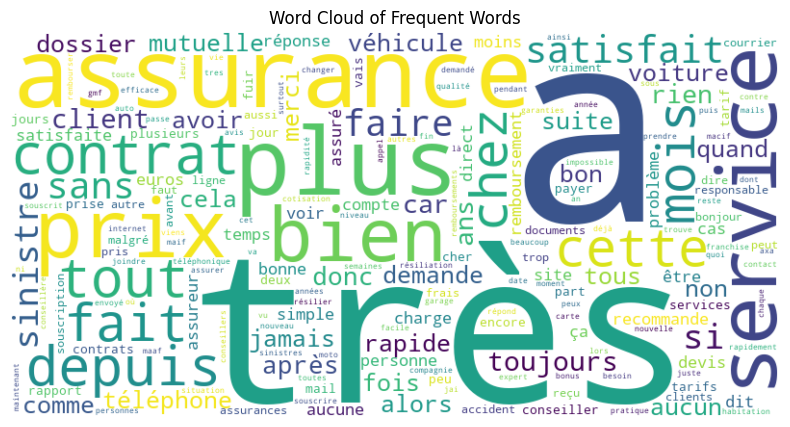

In [260]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word Cloud for single words
wordcloud = (WordCloud(width=800, height=400, background_color='white', min_word_length=0).fit_words(word_counts))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Frequent Words")
plt.show()

### Most common n-grams

The most common 2 and 3 grams will be displayed in a bar chart.

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,3))  # bigrams and trigrams
ngrams = vectorizer.fit_transform(df['avis'])

ngram_counts = pd.DataFrame(ngrams.sum(axis=0), columns=vectorizer.get_feature_names_out()).T
ngram_counts.columns = ['Frequency']
ngram_counts = ngram_counts.sort_values(by='Frequency', ascending=False).head(100)

ngram_counts

,Frequency
cette assurance,2303
service client,2088
direct assurance,1830
satisfait service,1729
prise charge,1350
...,...
sinistre non,231
prendre charge,230
prise compte,226
nouveau contrat,226


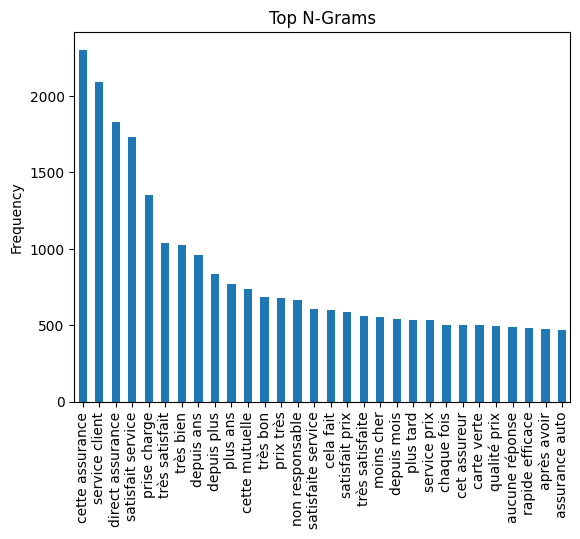

In [267]:
import matplotlib.pyplot as plt

ngram_counts.head(30).plot(kind='bar', legend=False)
plt.title("Top N-Grams")
plt.ylabel("Frequency")
plt.show()

# 3. Topic Modeling
DA SISTEMARE E CAPIRE SE è CORRETTO
## Topic Modeling with LDA

In this section we will perform a topic modeling analysis on the reviews using the Latent Dirichlet Allocation (LDA) algorithm.

In [45]:
num_topics = 4

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)  # Adjust for French stopwords
tfidf_matrix = vectorizer.fit_transform(df['avis'])

# Get feature names
terms = vectorizer.get_feature_names_out()

from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

# Display topics
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[f"Topic {topic_idx + 1}"] = top_words
    return topics

topics = display_topics(lda, terms, no_top_words=10)
print("Topics and their top words:")
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

Topics and their top words:
Topic 1: ans, plus, depuis, sinistre, bonus, assurance, sans, année, chez, augmentation
Topic 2: prix, satisfait, très, service, assurance, rapide, simple, recommande, bien, satisfaite
Topic 3: très, satisfaite, service, satisfait, merci, bon, téléphonique, bien, bonne, accueil
Topic 4: plus, mois, depuis, contrat, assurance, fait, toujours, faire, cette, tout


Given the 4 resulting topics and theri top words we can assign a title to each topic.

Topic 1: **Policy Claims**

The presence of words like ans (years), depuis (since), and augmentation (increase) suggests discussions about long-term experiences, possibly related to policy terms, claim history (sinistre), and premium increases.

Topic 2: **Satisfaction and Pricing**

Words like prix (price), satisfait (satisfied), and recommande (recommend) suggest reviews discussing pricing, satisfaction, and general feedback about service and value.

Topic 3: **Service Experience**

Words like téléphonique (phone), accueil (welcome), and service (service) imply feedback related to customer service interactions, especially over the phone.

Topic 4: **Contracts and Policy Management**

Words like contrat (contract), depuis (since), and fait (done) indicate discussions about contracts, durations, and issues regarding agreements or policies.

We can then annotate the topics in the dataset.



In [48]:
# Assign the most probable topic to each document
document_topics = lda.transform(tfidf_matrix)
df['topic'] = document_topics.argmax(axis=1) + 1

topic_labels = {
    1: "Policy Claims",
    2: "Satisfaction and Pricing",
    3: "Service Experience",
    4: "Contracts and Policy Management"
}

df['topic'] = df['topic'].map(topic_labels)

We can save the dataset with the assigned topics.

In [53]:
df.to_pickle(os.path.join(data_path, 'dataset_cleaned_topics.pkl'))

## Topic Visualization

We can use an heatmap to visualize the topics and their top words.

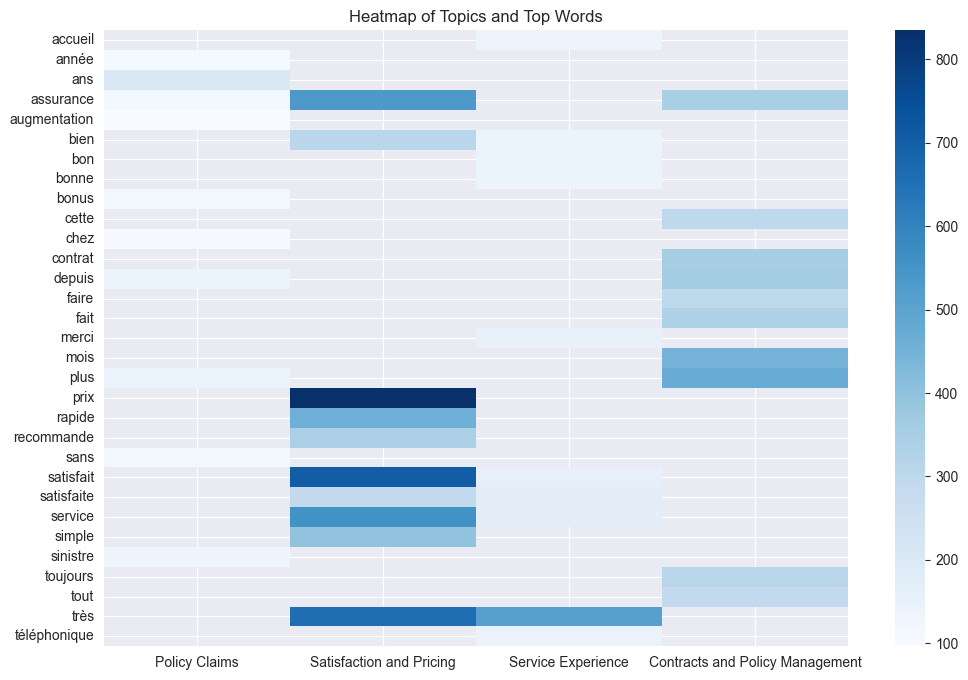

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dataframe for heatmap
import pandas as pd
heatmap_data = pd.DataFrame(lda.components_, index=[f"{topic_labels[i+1]}" for i in range(num_topics)], columns=terms)
top_terms_per_topic = heatmap_data.apply(lambda x: x.nlargest(10), axis=1)  # Top 10 terms per topic

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_terms_per_topic.T, annot=False, cmap='Blues')
plt.title("Heatmap of Topics and Top Words")
plt.show()

# 4. Embedding to Identify Similar Words

In this section we will train a Word2Vec model on the reviews to identify similar words.

In [296]:
# Train Word2Vec model
tokenized_reviews = [word_tokenize(review) for review in df['avis']]
model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4, sg=1)

# Function to find similar words
def find_similar_words(word, topn=10):
    try:
        similar_words = model.wv.most_similar(word, topn=topn)
        return similar_words
    except KeyError:
        return f"Word '{word}' not in vocabulary."

# Test with a sample word
word_to_check = "prix"  # Example word in French
similar_words = find_similar_words(word_to_check)
print(f"Words similar to '{word_to_check}':")
for similar_word, similarity in similar_words:
    print(f"{similar_word}: {similarity:.4f}")


Words similar to 'prix':
tarif: 0.8549
tarifs: 0.8379
qualitéprix: 0.7638
serviceprix: 0.7630
rapideprix: 0.7476
proposées: 0.7460
cohérent: 0.7453
prixje: 0.7434
loffre: 0.7405
tarification: 0.7402


### Visualization with TensorBoard (BROKEN)

In [307]:
# Prepare embeddings and metadata in memory
word_vectors = model.wv.vectors
word_list = model.wv.index_to_key

# Set up TensorBoard directory
log_dir = tempfile.mkdtemp()  # Temporary directory for TensorBoard logs

# Create a tensor for embeddings
embedding_tensor = tf.Variable(word_vectors, name="word_embeddings")

# Write metadata (word list) to the log directory
metadata_path = os.path.join(log_dir, "metadata.tsv")
with open(metadata_path, "w") as f:
    for word in word_list:
        f.write(f"{word}\n")

# Use TensorFlow SummaryWriter to log embeddings
writer = tf.summary.create_file_writer(log_dir)
with writer.as_default():
    tf.summary.scalar("embedding", 0, step=0)  # Placeholder to create graph
    writer.flush()

# Configure projector
from tensorboard.plugins.projector import ProjectorConfig, visualize_embeddings

config = ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_tensor.name
embedding.metadata_path = "metadata.tsv"

visualize_embeddings(log_dir, config)

# Launch TensorBoard
print(f"Run the following command to launch TensorBoard:\n\ntensorboard --logdir {log_dir}")

Run the following command to launch TensorBoard:

tensorboard --logdir /var/folders/yg/gp8smp8d1cx2j1t_sxxl13580000gn/T/tmpnil2l26_


### t-SNE Visualization

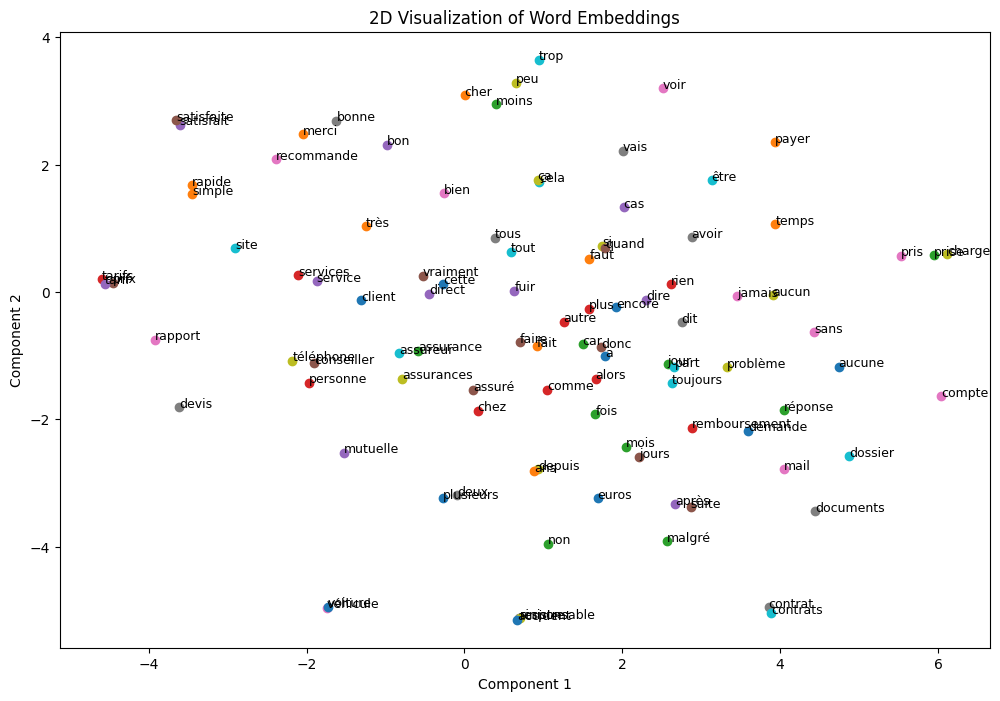

In [306]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions using t-SNE
words = list(model.wv.index_to_key)[:100]  # Limit to first 100 words for clarity
word_vectors = model.wv[words]
tsne = TSNE(n_components=2, random_state=42)
word_embeddings_2d = tsne.fit_transform(word_vectors)

# Plot with Matplotlib
plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]), fontsize=9)
plt.title("2D Visualization of Word Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


# 5. 6. Modelling

## TF-IDF (CREDO SIA  VERAMENTE TROPPO SEMPLICE)

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of words in a document relative to a corpus. It’s commonly used for feature extraction in text classification tasks.

In this part, we’ll simplify the task by predicting binary sentiment classification (positive or negative sentiment) using TF-IDF and classical machine learning algorithms like Logistic Regression. The dataset will be labeled with “positive” if the rating is 4 or 5 and “negative” if the rating is 1 or 2. Ratings of 3 will be excluded to maintain a clear distinction between positive and negative classes.

In [58]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

reviews = df[['avis', 'note']].copy()

# Simplify sentiment into binary classification (positive or negative)
def label_sentiment(row):
    if row['note'] >= 4:
        return "positive"
    elif row['note'] <= 2:
        return "negative"
    else:
        return None

reviews['sentiment'] = reviews.apply(label_sentiment, axis=1)
reviews = reviews.dropna(subset=['sentiment'])  # Drop rows with neutral sentiment (3 stars)

# Split data into training and test sets
X = reviews['avis']  # Preprocessed reviews
y = reviews['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer()  # Limit to top 5000 features for simplicity
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=200, random_state=42)
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Example usage
example_review = "Service client va bien."
example_tfidf = vectorizer.transform([example_review])
predicted_sentiment = model.predict(example_tfidf)
print(f"Predicted Sentiment for '{example_review}': {predicted_sentiment[0]}")

Accuracy: 0.9397

Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.96      0.94      2165
    positive       0.95      0.92      0.94      1980

    accuracy                           0.94      4145
   macro avg       0.94      0.94      0.94      4145
weighted avg       0.94      0.94      0.94      4145

Predicted Sentiment for 'Service client va bien.': positive


##  Basic Model with Embedding Layer

The model developed in this section aims to predict the star rating (on a scale from 1 to 5) of customer reviews using a basic neural network with an embedding layer. This model will learn word representations directly from the dataset, making it well-suited for handling vocabulary and context specific to the reviews.

### Data Preparation

As first step, the textual data is preprocessed by splitting the data into training and test sets, scaling the target star ratings to the range [0, 1], and tokenizing and padding the review text into uniform sequences. Invalid target values are removed to ensure the data is clean and suitable for training the neural network.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.initializers import RandomUniform

# Load the dataset
reviews = df[['avis', 'note']].copy()

# Prepare data: Input (reviews) and target (star ratings)
X = reviews['avis']  # Preprocessed reviews
y = reviews['note']  # Star ratings (1-5)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale target values to the range [0, 1]
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Tokenize and pad sequences
max_words = 10000  # Vocabulary size
max_len = 100  # Maximum length of sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Remove or replace invalid targets
valid_indices = ~pd.isnull(y_train_scaled).ravel()
X_train_padded = X_train_padded[valid_indices]
y_train_scaled = y_train_scaled[valid_indices]

valid_indices = ~pd.isnull(y_test_scaled).ravel()
X_test_padded = X_test_padded[valid_indices]
y_test_scaled = y_test_scaled[valid_indices]

### Model Building and Training

The model is built with the following caracteristics:
- **Embedding Layer**: The network starts with an embedding layer, which maps each word to a dense vector representation of fixed size. This layer is trained during the model fitting, enabling the network to learn semantic relationships between words. Instead of using pre-trained embeddings, we let the model learn embeddings specific to the dataset, capturing unique word usage patterns in customer reviews.
- **Global Average Pooling**: A global average pooling layer aggregates the word embeddings for each review, providing a fixed-size representation regardless of the review length. This layer simplifies the model by aggregating information from all words in a review into a single fixed-length vector, reducing computational complexity and overfitting risk.
- **Fully Connected Dense Layer**: A fully connected dense layer applies non-linear transformations to learn complex patterns.
- **Regression Output**: The final output layer is a single neuron with a linear activation function, designed to predict a continuous value (the star rating).
- **Optimization**: Adam optimizer with gradient clipping is used to prevent issues like exploding gradients.


In [8]:
# Build a neural network with an embedding layer
embedding_dim = 50  # Dimension of word embeddings

model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              embeddings_initializer=RandomUniform(minval=-0.05, maxval=0.05)),  # Proper initialization
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean Squared Error and Mean Absolute Error

# Train the model
history = model.fit(X_train_padded, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_padded, y_test_scaled, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.4f}")

Epoch 1/10


/opt/anaconda3/envs/Project1-MachineLearningForNLP/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1056 - mae: 0.2724 - val_loss: 0.0581 - val_mae: 0.1950
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0540 - mae: 0.1869 - val_loss: 0.0605 - val_mae: 0.1959
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0476 - mae: 0.1731 - val_loss: 0.0485 - val_mae: 0.1728
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0406 - mae: 0.1567 - val_loss: 0.0494 - val_mae: 0.1792
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0376 - mae: 0.1492 - val_loss: 0.0487 - val_mae: 0.1701
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0342 - mae: 0.1422 - val_loss: 0.0471 - val_mae: 0.1727
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0325 - mae: 0.1369 - val_loss: 0.0579 - val_mae: 0.1862
Epoch 8/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0290 - mae: 0.1293 - val_loss: 0.0489 - val_mae: 0.1701
Epoch 9/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0272 

The MSE loss decreases steadily and the MAE drops over 10 epochs: this shows that the model is learning effectively on the training data.

The validation MSE stabilizes around 0.05, and the MAE converged around 0.17: these values are close to the training metrics, indicating that the model generalizes well and is not overfitting.

Finally, on the test set, the MSE and the MAE obtained align closely with the validation performance.

In [74]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,509,989 (5.76 MB)

 Trainable params: 503,329 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,006,660 (3.84 MB)

In [13]:
# Save the model
model.save(os.path.join(models_path, 'star_rating_prediction_model.keras'))

### Model testing

The goal of this task is to predict star ratings based on review text: here we test the trained model with a sample review and evaluate its performance.

This implementation demonstrates the power of embeddings and basic neural networks in regression tasks, bridging textual and numerical data effectively.

In [9]:
# Example usage
example_review = "Service rapide et excellent."
example_seq = tokenizer.texts_to_sequences([example_review])
example_padded = pad_sequences(example_seq, maxlen=max_len, padding='post')
predicted_rating_scaled = model.predict(example_padded)
predicted_rating = scaler.inverse_transform(predicted_rating_scaled)
print(f"Predicted Rating for '{example_review}': {predicted_rating[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Rating for 'Service rapide et excellent.': 4.37


The predicted rating for the sample review is around 4.4, which makes sense for a review indicating high customer satisfaction. The prediction aligns with expectations, showcasing the model’s ability to interpret text sentiment accurately.

## Model with pre-trained embeddings

The model developed in this section aims to classify customer reviews into predefined categories (e.g., Pricing, Customer Service, etc.) using pre-trained embeddings. The embeddings capture semantic relationships between words and serve as input to a simple neural network for classification.

The development process involves the following steps:
1. Load pre-trained word embeddings (GloVe).
2. process the reviews (tokenize and pad).
3. Map the tokens to their pre-trained embedding vectors.
4. Train of a simple neural network on the embedding representations to classify reviews into categories.

### Data Preparation

The dataset and pre-trained embeddings are prepared for the neural network to classify reviews into predefined topics. The reviews are tokenized into sequences of integers and padded to ensure uniform length, while the target categories are converted into a one-hot encoded format for multi-class classification.

Next, pre-trained GloVe embeddings are loaded, which provide dense vector representations for words. An embedding matrix is constructed, where each row corresponds to a word in the vocabulary, and its values are initialized with the corresponding GloVe embedding if available. This matrix will later be used in the embedding layer of the neural network to incorporate semantic knowledge into the model.

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

# Load the dataset
# Replace this with the actual dataset path or loading code

# Prepare data: Input (reviews) and target (categories)
X = df["avis"]
y = pd.get_dummies(df['topic'])  # Convert categories to one-hot encoding

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
max_words = 10000  # Vocabulary size
max_len = 50       # Maximum length of sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Load pre-trained GloVe embeddings
embedding_dim = 50
embedding_index = {}
with open("glove.6B.50d.txt", encoding="utf-8") as f:  # Update to your GloVe file path
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

# Prepare the embedding matrix
word_index = tokenizer.word_index
num_tokens = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Model Building and Training

The model is built with the following layers, trying to simplicity and performance:

1. **Embedding Layer**: This layer initializes word embeddings with the pre-trained GloVe embeddings stored in the embedding_matrix. The embeddings are frozen (trainable=False), ensuring that the semantic relationships captured during pre-training are preserved and not overwritten during training. By using pre-trained embeddings, the model benefits from prior knowledge of word meanings, which enhances performance even with limited labeled data.
2. **Global Average Pooling Layer**: This layer reduces the sequence of word embeddings into a single fixed-length vector by averaging the embeddings across all words in a review. It simplifies the model by aggregating information, reducing the risk of overfitting, and ensuring that the input size is fixed regardless of the sequence length.
3. **Dense Layer (Hidden Layer)**: A fully connected layer with 64 units and a ReLU activation function introduces non-linearity to the model, allowing it to learn complex patterns in the data.
4. **Output Layer**: The output layer uses a softmax activation function and has as many neurons as the number of target categories (y_train.shape[1]), making it suitable for multi-class classification. The softmax function ensures that the outputs are probabilities for each category, allowing easy interpretation.

The model uses categorical crossentropy, which is the standard loss function for multi-class classification. It measures the difference between the predicted probability distribution and the true distribution. Additionally, the Adam optimizer is chosen for its efficiency and ability to adapt learning rates during training, leading to faster convergence.

In [54]:
# Build the model
model = Sequential([
    Embedding(input_dim=num_tokens,
              output_dim=embedding_dim,
              embeddings_initializer=Constant(embedding_matrix),
              input_length=max_len,
              trainable=False),  # Freeze embeddings
    GlobalAveragePooling1D(),
    Dense(64, activation="relu"),
    Dense(y_train.shape[1], activation="softmax")  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10


/opt/anaconda3/envs/Project1-MachineLearningForNLP/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


689/689 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.5493 - loss: 1.0615 - val_accuracy: 0.6509 - val_loss: 0.8425
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6612 - loss: 0.8293 - val_accuracy: 0.6704 - val_loss: 0.8020
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6739 - loss: 0.8021 - val_accuracy: 0.6740 - val_loss: 0.7885
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6760 - loss: 0.7937 - val_accuracy: 0.6780 - val_loss: 0.7803
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6774 - loss: 0.7823 - val_accuracy: 0.6789 - val_loss: 0.7759
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6840 - loss: 0.7814 - val_accuracy: 0.6823 - val_loss: 0.7756
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.6907 - loss: 0.7674 - val_accuracy: 0.6856 - val_loss: 0.7696
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6870 - loss: 0.7749 - val_accurac

In [60]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 50)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,574 (1.95 MB)

 Trainable params: 3,524 (13.77 KB)

 Non-trainable params: 500,000 (1.91 MB)

 Optimizer params: 7,050 (27.54 KB)

In [61]:
# Save the model
model.save(os.path.join(models_path, 'topic_classification_model.keras'))

### Model testing

The goal of this task is to predict the category of a review based on its content. Here we test the trained model with a sample review and evaluate its performance.

In [59]:
# Example prediction
example_review = "Prix raisonnables pour un bon service"
example_seq = tokenizer.texts_to_sequences([example_review])
example_padded = pad_sequences(example_seq, maxlen=max_len, padding='post')
predicted_category = model.predict(example_padded)
category_labels = y.columns
predicted_label = category_labels[np.argmax(predicted_category)]
print(f"Predicted Category for '{example_review}': {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted Category for 'Prix raisonnables pour un bon service': Satisfaction and Pricing


The predicted category for the sample review is "Satisfaction and Pricing," which aligns with the content of the review. The model successfully classified the review into the correct category, demonstrating its ability to generalize and make accurate predictions on unseen data.

# 7. Streamlit Applications